In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Load data.
data = read_csv('data.csv')

## Exclusion Criteria

#### [Albrecht et al. (2016)](https://doi.org/10.1371/journal.pone.0152781)
- Exclude participants unable to learn the easiest condition (Go-to-Win), defined as less than five correct responses.
- Exclude participants for lack of deviance in responding, defined as making an extended run (> 40) of "Go" responses or "No-Go" responses. 

#### [Mkrtchian et al. (2017)](https://doi.org/10.1016/j.biopsych.2017.01.017)
- Exclude participants who fail to "follow task instructions".

#### [Millner et al. (2018)](https://doi.org/10.1162/jocn_a_01224)
- Exclude participants for selecting go on every escape trial.

#### [Swart et al. (2018)](https://doi.org/10.1371/journal.pbio.2005979)
- No behavioral exclusion criteria reported.

#### [Csifcsal et al. (2019/202X)](https://doi.org/10.1162/jocn_a_01515)
- Exclude participants that do not try out both response options (response, no response) for all 4 card types at least once. 

## Section 1: Missing Data

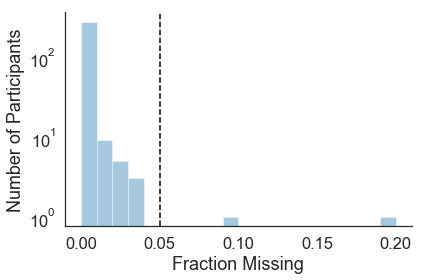

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define threshold.
cutoff = 0.05

## Compute fraction of missing data.
data['Missing'] = data.Accuracy.isnull()
gb = data.groupby(['Study','Subject']).Missing.mean()

## Exclude participants.
data = data.groupby(['Study','Subject']).filter(lambda x: x.Missing.mean() < cutoff)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot missing data.
ax = sns.distplot(gb, bins=np.linspace(0,0.2,21), kde=False, ax=ax)
ax.axvline(cutoff, color='k', linestyle='--')
ax.set_yscale('log')
ax.set(xlabel='Fraction Missing', ylabel='Number of Participants')

sns.despine()
plt.tight_layout()

## Section 2: Accuracy

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Identify trials.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Identify any go-response on GW trials.
data['GW'] = np.where((data.Valence=="Win")&(data.Action=="Go"), 1, np.nan)
data['GW'] = np.where(data.Choice > 0, 1, 0) * data['GW']

## Identify any response on GAL trials.
data['GAL'] = np.where((data.Valence=="Lose")&(data.Action=="Go"), 1, np.nan)
data['GAL'] = np.where(data.Choice > 0, 1, 0) * data['GAL']

## Identify no-go response on NGW trials.
data['NGW'] = np.where((data.Valence=="Win")&(data.Action=="No-Go"), 1, np.nan)
data['NGW'] = np.where(data.Choice > 0, 0, 1) * data['NGW']

## Identify no-go response on NGAL trials.
data['NGAL'] = np.where((data.Valence=="Lose")&(data.Action=="No-Go"), 1, np.nan)
data['NGAL'] = np.where(data.Choice > 0, 0, 1) * data['NGAL']

### Section 2.1: Go to Win Accuracy

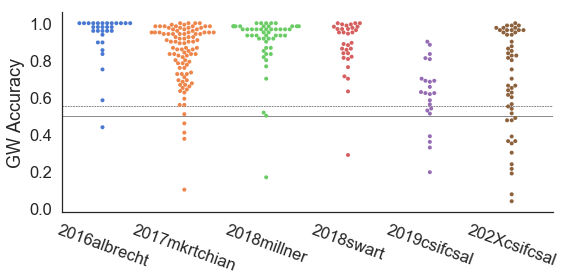

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute response accuracy within subjects.
gb = data.groupby(['Study','Subject']).GW.mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot scores.
sns.swarmplot('Study', 'GW', data=gb, palette='muted', size=4,  ax=ax)
ax.axhline(0.50, color='0.1', lw=0.5)
ax.axhline(0.55, color='0.1', lw=0.5, linestyle='--')

## Add details.
ax.set(xlabel='',ylabel='GW Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-20)

sns.despine()
plt.tight_layout()

With the exception of the Csifcsal studies, the vast majority of participants are above the hard cutoff of 50% accuracy and a soft cutoff of 55% accuracy. The Csifcsal studies are interesting though. The task design explicitly penalizes action. In some sense then, it isn't surprising that a large fraction of show poor performance on Go to Win trials. This raises some concern, however, that all participants should be excluded because they are learning different statistics than participants in other studies.

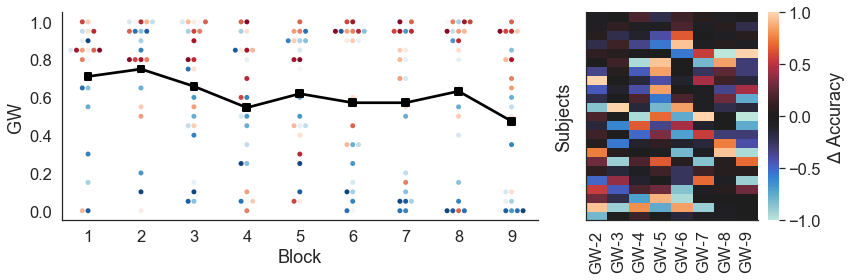

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Restrict to Csifcsal et al. (2019).
gb = data.query('Study == "2019csifcsal"')

## Compute GW accuracy within subjects/blocks.
gb = gb.groupby(['Subject','Block']).GW.mean().reset_index()
gb = gb.query('Block < 10')

## Rank participants.
order = gb.groupby('Subject').GW.mean().sort_values().index

## Compute change in accuracy between blocks.
pivot = gb.pivot_table(index='Subject',columns='Block')
pivot = pivot.loc[order]
pivot = pivot.T.diff().dropna().T

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Plot scores.
ax = plt.subplot2grid((1,3),(0,0),colspan=2)
ax = sns.swarmplot('Block', 'GW', hue='Subject', data=gb, hue_order=order, palette='RdBu_r', 
                   zorder=0, ax=ax)
sns.pointplot('Block', 'GW', data=gb, color='k', markers='s', ci=None, ax=ax)

## Add detail.
ax.legend_.set_visible(False)
ax.set(ylim=(-0.05,1.05))

## Plot deltas.
ax = plt.subplot2grid((1,3),(0,2))
sns.heatmap(pivot, vmin=-1, vmax=1, center=0, cbar_kws={'label': r'$\Delta$ Accuracy'}, ax=ax)

## Add detail.
ax.set(xlabel='', yticklabels=[], ylabel='Subjects')
ax.invert_yaxis()

sns.despine()
plt.tight_layout()

The plots above show high variability in accuracy across blocks. This may reflect one of several task features: a) the short nature of each block (20 presentations of each cue); b) reduced discriminability (70% accurate feedback); c) changing task strategy; or d) coding errors (e.g. yoked participants accidentally in sample, due to my coding error). In any event, this suggests we should consider avoiding analysis of this datasets.

In [6]:
## Define cutoff.
cutoff = 0.55

## Exclude participants.
data = data.groupby(['Study','Subject']).filter(lambda x: x.GW.mean() > cutoff)

### Section 2.2: No-Go to Avoid Losing Accuracy

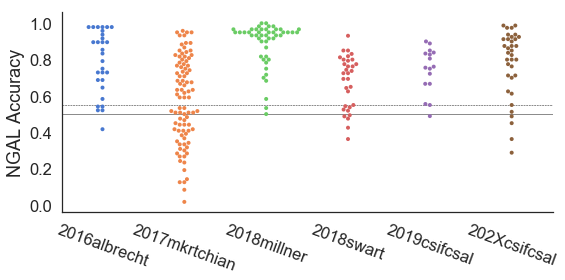

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute response accuracy within subjects.
gb = data.groupby(['Study','Subject']).NGAL.mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot scores.
sns.swarmplot('Study', 'NGAL', data=gb, palette='muted', size=4,  ax=ax)
ax.axhline(0.50, color='0.1', lw=0.5)
ax.axhline(0.55, color='0.1', lw=0.5, linestyle='--')

## Add details.
ax.set(xlabel='',ylabel='NGAL Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-20)

sns.despine()
plt.tight_layout()

In [8]:
## Define cutoff.
cutoff = 0.55

## Exclude participants.
data = data.groupby(['Study','Subject']).filter(lambda x: x.NGAL.mean() > cutoff)

### Section 2.3: Go to Avoid Losing

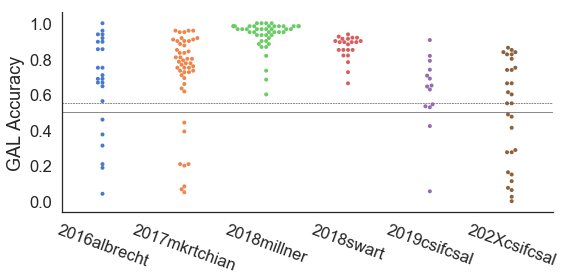

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute response accuracy within subjects.
gb = data.groupby(['Study','Subject']).GAL.mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot scores.
sns.swarmplot('Study', 'GAL', data=gb, palette='muted', size=4,  ax=ax)
ax.axhline(0.50, color='0.1', lw=0.5)
ax.axhline(0.55, color='0.1', lw=0.5, linestyle='--')

## Add details.
ax.set(xlabel='',ylabel='GAL Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-20)

sns.despine()
plt.tight_layout()

### Section 2.4: No-Go to Win

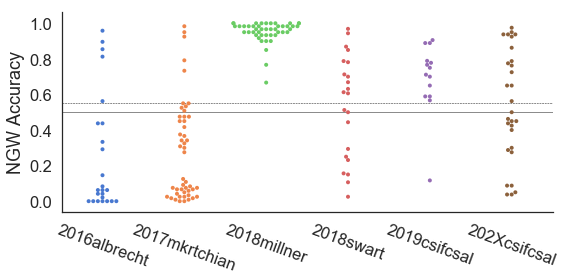

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute response accuracy within subjects.
gb = data.groupby(['Study','Subject']).NGW.mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot scores.
sns.swarmplot('Study', 'NGW', data=gb, palette='muted', size=4,  ax=ax)
ax.axhline(0.50, color='0.1', lw=0.5)
ax.axhline(0.55, color='0.1', lw=0.5, linestyle='--')

## Add details.
ax.set(xlabel='',ylabel='NGW Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-20)

sns.despine()
plt.tight_layout()

### Section 2.5: Summary

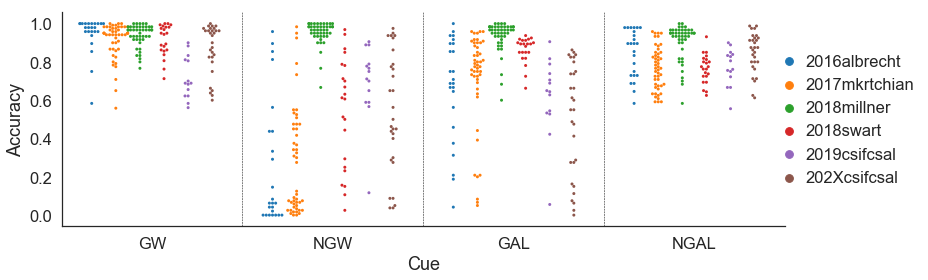

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute response accuracy within subjects.
gb = data.groupby(['Study','Subject'])[['GW','GAL','NGW','NGAL']].mean().reset_index()

## Melt data.
gb = gb.melt(id_vars=['Study','Subject'], var_name='Cue', value_name='Accuracy')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(13,4))

## Plot accuracies.
order = ['GW','NGW','GAL','NGAL']
sns.swarmplot('Cue', 'Accuracy', 'Study', data=gb, order=order, dodge=True, size=3, ax=ax)
ax.legend(loc=7, bbox_to_anchor=(1.2,0.5), frameon=False, handletextpad=0)
for i in range(3): ax.axvline(i+0.5, color='k', lw=0.5, linestyle='--')
    
sns.despine()
plt.tight_layout()

### Section 2.6: Dataset Similarity

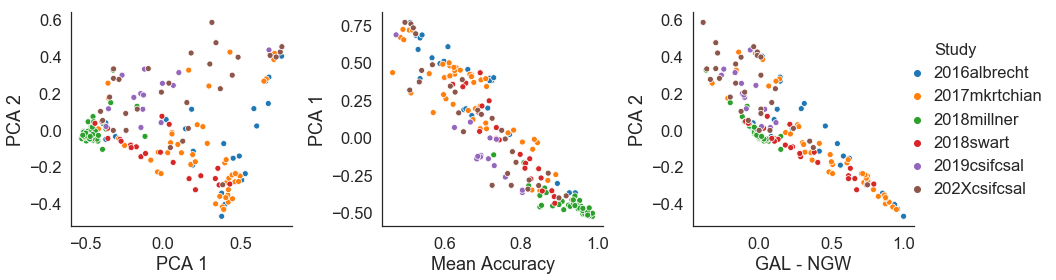

In [12]:
from sklearn.decomposition import PCA

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Dimensionality reduction.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average accuracy within subjects. 
gb = data.groupby(['Study','Subject'])[['GW','GAL','NGW','NGAL']].mean().reset_index()

## Decompose scores.
pca = PCA(n_components=4)
X = pca.fit_transform(gb[gb.columns[-4:]])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(15,4))

## Plot principal components.
ax = sns.scatterplot(X[:,0], X[:,1], hue=gb['Study'], legend=False, ax=axes[0])
ax.set(xlabel='PCA 1', ylabel='PCA 2')

## Plot error rates.
y = gb[['GW','GAL','NGW','NGAL']].mean(axis=1)
ax = sns.scatterplot(y, X[:,0], hue=gb['Study'], legend=False, ax=axes[1])
ax.set(xlabel='Mean Accuracy', ylabel='PCA 1')

## Plot accuracy.
y = gb['GAL'] - gb['NGW']
ax = sns.scatterplot(y, X[:,1], hue=gb['Study'], ax=axes[2])
ax.set(xlabel='GAL - NGW', ylabel='PCA 2')
ax.legend(loc=7, bbox_to_anchor=(1.65,0.5), frameon=False, handletextpad=0)

sns.despine()
plt.tight_layout()

## Section 3: Learning Curves

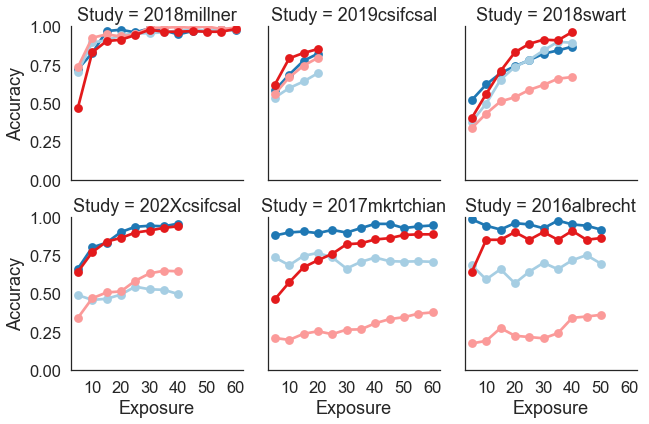

In [13]:
gb = data.groupby(['Study','Valence','Action','Exposure']).Accuracy.mean().reset_index()
gb['Cue'] = gb.apply(lambda x: f'{x.Action}-{x.Valence}', 1)
gb['Cue'] = gb.Cue.replace({'Go-Win':'GW', 'No-Go-Win':'NGW', 'Go-Lose':'GAL', 'No-Go-Lose':'NGAL'})
gb['Exposure'] = (gb['Exposure'] - 1) // 5


col_order = ['2018millner','2019csifcsal','2018swart','202Xcsifcsal','2017mkrtchian','2016albrecht']
palette = ['#1f78b4','#a6cee3','#fb9a99', '#e31a1c']

g = sns.FacetGrid(gb, col='Study', col_order=col_order, col_wrap=3)
g.map(sns.pointplot, 'Exposure', 'Accuracy', 'Cue', palette=palette, 
      hue_order=['GW','GAL','NGW','NGAL'], order=np.arange(12), ci=None)
g.set(xticks=np.arange(1,12,2), xticklabels=np.arange(10,65,10), ylim=(0,1))

In [14]:
## Exclude participants.
data = data.query('Study!="2018millner"')

In [16]:
data.shape

(61088, 19)

In [23]:
T = data.groupby('Study').Subject.count()
N = data.groupby('Study').Subject.nunique()
C = data.groupby('Study').Cue.nunique()